In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import seaborn as sns
import rasterio as rio
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
import disco_tif.process_sb_tiff
import disco_tif.hillshades_pca
import disco_tif.geotiff_plotting
import disco_tif.write_mapfile

In [5]:
import datetime
def nowTime():
    return datetime.datetime.now().strftime("%H:%M:%S")
def now():
    return datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
def snow():
    return datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
def today():
    return datetime.datetime.now().strftime("%Y-%m-%d")
def stoday():
    return datetime.datetime.now().strftime("%Y%m%d")

# grab the hexcolor codes from the file

In [6]:
EMerald_colors_hex = disco_tif.process_sb_tiff.EMerald_custom_colors_hexcolorcodes
EMerald_colors_hex

['#0000ff',
 '#01ffff',
 '#3fca3f',
 '#f19898',
 '#deb201',
 '#896651',
 '#f1bfff',
 '#fffafc']

In [7]:
sns.color_palette(EMerald_colors_hex)

[(0.0, 0.0, 1.0),
 (0.00392156862745098, 1.0, 1.0),
 (0.24705882352941178, 0.792156862745098, 0.24705882352941178),
 (0.9450980392156862, 0.596078431372549, 0.596078431372549),
 (0.8705882352941177, 0.6980392156862745, 0.00392156862745098),
 (0.5372549019607843, 0.4, 0.3176470588235294),
 (0.9450980392156862, 0.7490196078431373, 1.0),
 (1.0, 0.9803921568627451, 0.9882352941176471)]

# test hex to rgb functionality

In [8]:
EMerald_colors_rgb = pd.DataFrame()
for ii in range(0, len(EMerald_colors_hex)):
    hexcolor = EMerald_colors_hex[ii]
    EMerald_colors_rgb.loc[ii, ['r','g','b']] = disco_tif.process_sb_tiff.hex_to_rgb(hexcolor)[0], \
                                                disco_tif.process_sb_tiff.hex_to_rgb(hexcolor)[1], \
                                                disco_tif.process_sb_tiff.hex_to_rgb(hexcolor)[2]
EMerald_colors_rgb

,r,g,b
0,0,0,255
1,1,255,255
2,63,202,63
3,241,152,152
4,222,178,1
5,137,102,81
6,241,191,255
7,255,250,252


In [9]:
#ii=1
for ii in range(0,len(EMerald_colors_rgb)):
    print(disco_tif.process_sb_tiff.rgb_to_hex(EMerald_colors_rgb.loc[ii, 'r'], EMerald_colors_rgb.loc[ii, 'g'], EMerald_colors_rgb.loc[ii, 'b']))

#0000ff
#01ffff
#3fca3f
#f19898
#deb201
#896651
#f1bfff
#fffafc


# define single-band geotiff

In [10]:
tiff_dir = os.getcwd()

single_band_tiff_path = os.path.abspath('../example_data/E020N40/E020N40.tif')

single_band_tiff_path

'/Users/bbloss/EMeraldCodes/disco-tif/example_data/E020N40/E020N40.tif'

# inspect colormap generator function

In [11]:
# read data and minimally process for the colormap function
with rio.open(single_band_tiff_path, 'r') as src:
    data = src.read(1)  # Read the first band
    no_data_value = src.nodata  # Get the no-data value from the GeoTIFF
    epsg_code = src.crs.to_epsg() if src.crs else None
    origprofile = src.profile
    data_min_max = [np.min(data[data!=no_data_value]), np.max(data)]
    mask = src.read_masks(1)

print(f"no_data_value = {no_data_value}")
print(f"data_min_max = {data_min_max}")
print(f"epsg_code = {epsg_code}")
print(f"src.crs = {src.crs}")
print(f"origprofile = {origprofile}")
print(f"mask = {mask}")

no_data_value = -9999.0
data_min_max = [-407, 5825]
epsg_code = 4326
src.crs = EPSG:4326
origprofile = {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 4800, 'height': 6000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333333330003, 0.0, 20.000000000000004,
       0.0, -0.00833333333333, 39.99999999999999), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
mask = [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]]


In [12]:
datarange = data_min_max
datarange

[-407, 5825]

In [13]:
# dataranges to test
#datarange = [-1, 2000]
#datarange = [-1, 4000]
datarange = [-28, 2540]
#datarange = [-285, 4000]
#datarange = [-400, 400]
#datarange = [-400, 0]
#datarange = [-400, -1]
#datarange = [-249, 6]
#datarange = [0, 5000]
#datarange = [0, 500]
#datarange = [0, 255]
#datarange = [0, 60]
#datarange = [0, 54]
#datarange = [1, 1500]
#datarange = [1000, 5000]
#datarange = [200, 100]
#datarange = [100, 200]
#datarange = [44, 255]
#datarange = [-200, 200]

datarange

[-28, 2540]

In [14]:
data_with_nan = data.copy().astype(float)
if no_data_value is not None:
    data_with_nan[data==no_data_value]=np.nan

np.nanmin(data_with_nan)

-407.0

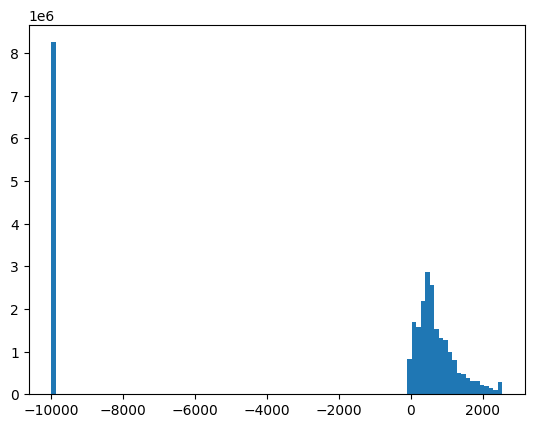

In [15]:
# Clip data values to the specified range
clipped_data = np.clip(data, datarange[0], datarange[1])

# un-clip the orig_data with no_data_vaules to exclude from the perenctile calculations
clipped_data_with_dum = clipped_data.copy()
if no_data_value is not None:
    clipped_data_with_dum[data==no_data_value] = no_data_value


plt.hist(clipped_data_with_dum.flatten().flatten(), bins=min(datarange[1]-datarange[0], 100))
plt.show()

datarange = [-28, 2540]


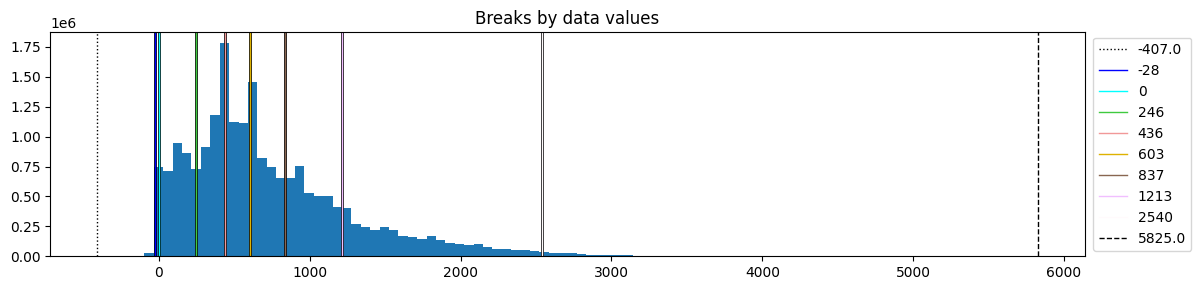

breaks_data = [-28, 0, 246, 436, 603, 837, 1213, 2540]
percentile_breaks = [0.         0.01090343 0.10669782 0.18068536 0.24571651 0.33683801
 0.48325545 1.        ]


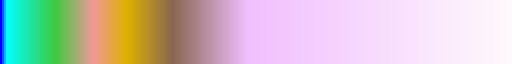

In [16]:
# make percentile ranges for pseudo_hist_norm
cmap_method = 'pseudo_hist_norm'

print(f"datarange = {datarange}")
breaks_data = disco_tif.process_sb_tiff.make_percentile_array(data_min_max=datarange,
                                                              data=data,
                                                              no_data_value=no_data_value,
                                                              cmap_method=cmap_method,
                                                              plot_histograms=True)
print(f"breaks_data = {breaks_data}")
percentile_breaks = (np.array(breaks_data) - datarange[0]) / (datarange[1] - datarange[0])
print(f"percentile_breaks = {percentile_breaks}")
EMeraldCustomColorMap = disco_tif.process_sb_tiff.build_EMerald_terrain_colormap(percentile_breaks)
EMeraldCustomColorMap

datarange = [-28, 2540]


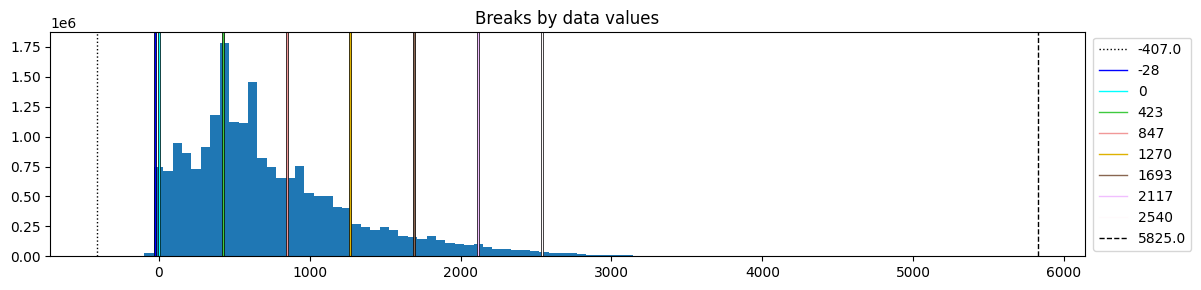

[-28, 0, 423, 847, 1270, 1693, 2117, 2540]
percentile_breaks = [0.         0.01090343 0.17562305 0.34073209 0.50545171 0.67017134
 0.83528037 1.        ]


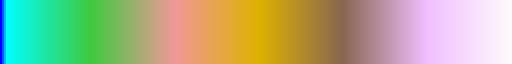

In [17]:
# make percentile ranges for pseudo_linear
cmap_method = 'pseudo_linear'

print(f"datarange = {datarange}")
breaks_data = disco_tif.process_sb_tiff.make_percentile_array(data_min_max=datarange,
                                                              data=data,
                                                              no_data_value=no_data_value,
                                                              cmap_method=cmap_method,
                                                              plot_histograms=True)
print(breaks_data)
percentile_breaks = (np.array(breaks_data) - datarange[0]) / (datarange[1] - datarange[0])
print(f"percentile_breaks = {percentile_breaks}")
EMeraldCustomColorMap = disco_tif.process_sb_tiff.build_EMerald_terrain_colormap(percentile_breaks)
EMeraldCustomColorMap

# convert single-band geotiff to rgba geotiff

In [18]:
output_tif = None
output_tif = 'single_band_rgba' # default
#output_tif = 'multi_band_rgba'

output_QGIS_lut = True # defualt
#output_QGIS_lut = False
output_rgba_lut = True
#output_rgba_lut = False # defualt
output_uint8_lut = True
#output_uint8_lut = False # defualt

plot_rgba_raster = True
#plot_rgba_raster = False # defualt

In [19]:
data_min_max=None # defualt

min_max_method='percentile' # defualt

clip_perc=[1, 99] # defualt

color_palette_name=None # defualt

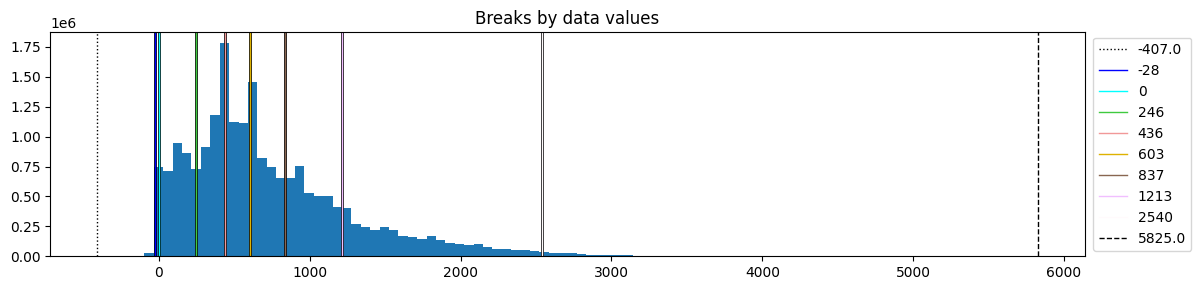


GIS software compatible color look up table sucessfully written to: 
	- /Users/bbloss/EMeraldCodes/disco-tif/example_data/E020N40/E020N40_EMeraldCustomTerrain_-28_to_2540_pseudo_hist_norm_qgis_color_table_256-colors_20240509.txt

Single-channel LUT files mapping data to color values have been written to: 
	- /Users/bbloss/EMeraldCodes/disco-tif/example_data/E020N40/E020N40_EMeraldCustomTerrain_-28_to_2540_pseudo_hist_norm_data_256-colors_20240509_r.lut 
	- /Users/bbloss/EMeraldCodes/disco-tif/example_data/E020N40/E020N40_EMeraldCustomTerrain_-28_to_2540_pseudo_hist_norm_data_256-colors_20240509_g.lut 
	- /Users/bbloss/EMeraldCodes/disco-tif/example_data/E020N40/E020N40_EMeraldCustomTerrain_-28_to_2540_pseudo_hist_norm_data_256-colors_20240509_b.lut 
	- /Users/bbloss/EMeraldCodes/disco-tif/example_data/E020N40/E020N40_EMeraldCustomTerrain_-28_to_2540_pseudo_hist_norm_data_256-colors_20240509_a.lut

multi-channel LUT file mapping data to color values has been written to: 
	- /Users/bblo

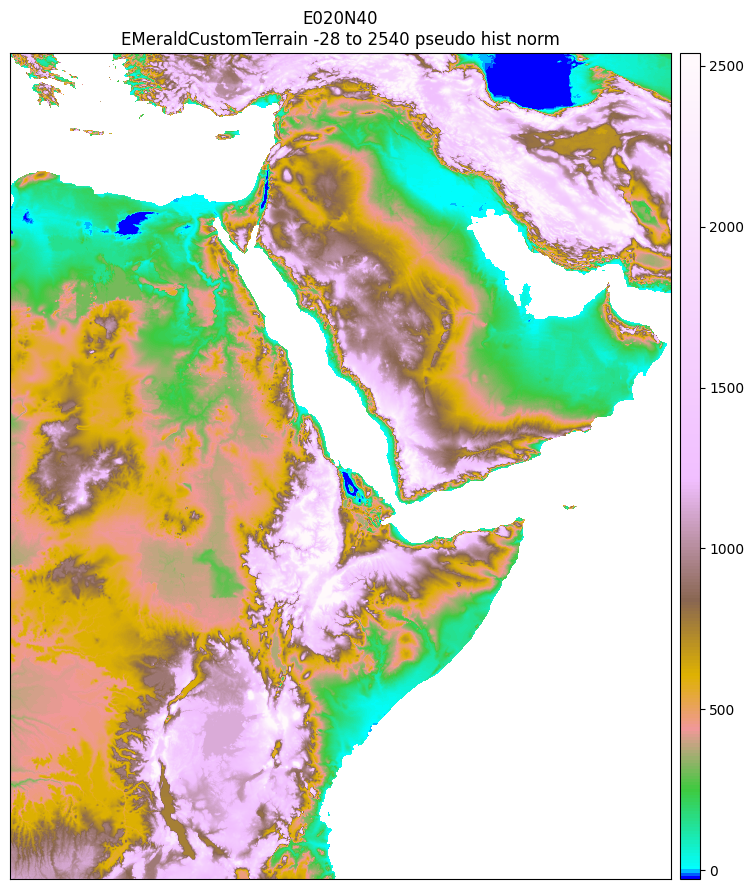


New single-channel colorized geotiff written to: 
	- '/Users/bbloss/EMeraldCodes/disco-tif/example_data/E020N40/E020N40_EMeraldCustomTerrain_-28_to_2540_pseudo_hist_norm.tif'

ph_data_breaks = [-28, 0, 246, 436, 603, 837, 1213, 2540]


In [88]:
cmap_method='pseudo_hist_norm' # defualt

ph_colormap, ph_data_breaks = disco_tif.process_sb_tiff.make_rgba_tiff_from_single_Band(single_band_tiff_path,
                                                                                        #data_min_max=datarange,
                                                                                        data_min_max=data_min_max,
                                                                                        cmap_method=cmap_method,
                                                                                        min_max_method=min_max_method,
                                                                                        clip_perc=clip_perc,
                                                                                        color_palette_name=color_palette_name,
                                                                                        output_tif=output_tif,
                                                                                        generate_QGIS_lut=output_QGIS_lut,
                                                                                        generate_rgba_luts=output_rgba_lut,
                                                                                        generate_data_uint8_lut=output_uint8_lut,
                                                                                        generate_uint8_luts=output_uint8_lut,
                                                                                        plot_rgba_raster=plot_rgba_raster)

print(f"ph_data_breaks = {ph_data_breaks}")

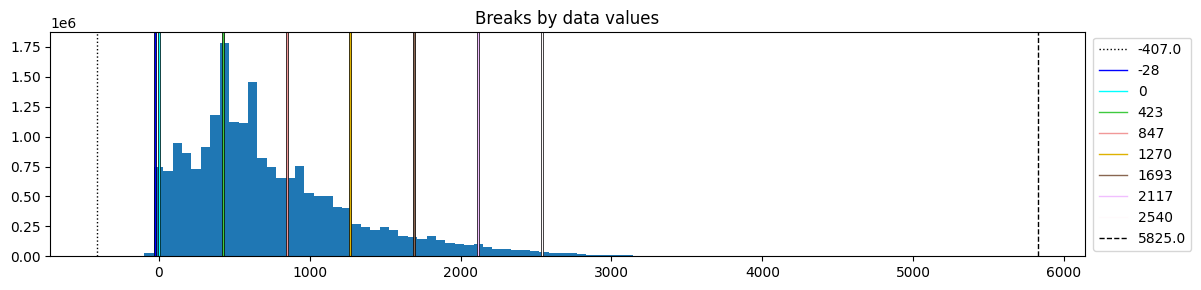


GIS software compatible color look up table sucessfully written to: 
	- /Users/bbloss/EMeraldCodes/disco-tif/example_data/E020N40/E020N40_EMeraldCustomTerrain_-28_to_2540_pseudo_linear_qgis_color_table_256-colors_20240509.txt

Single-channel LUT files mapping data to color values have been written to: 
	- /Users/bbloss/EMeraldCodes/disco-tif/example_data/E020N40/E020N40_EMeraldCustomTerrain_-28_to_2540_pseudo_linear_data_256-colors_20240509_r.lut 
	- /Users/bbloss/EMeraldCodes/disco-tif/example_data/E020N40/E020N40_EMeraldCustomTerrain_-28_to_2540_pseudo_linear_data_256-colors_20240509_g.lut 
	- /Users/bbloss/EMeraldCodes/disco-tif/example_data/E020N40/E020N40_EMeraldCustomTerrain_-28_to_2540_pseudo_linear_data_256-colors_20240509_b.lut 
	- /Users/bbloss/EMeraldCodes/disco-tif/example_data/E020N40/E020N40_EMeraldCustomTerrain_-28_to_2540_pseudo_linear_data_256-colors_20240509_a.lut

multi-channel LUT file mapping data to color values has been written to: 
	- /Users/bbloss/EMeraldCodes

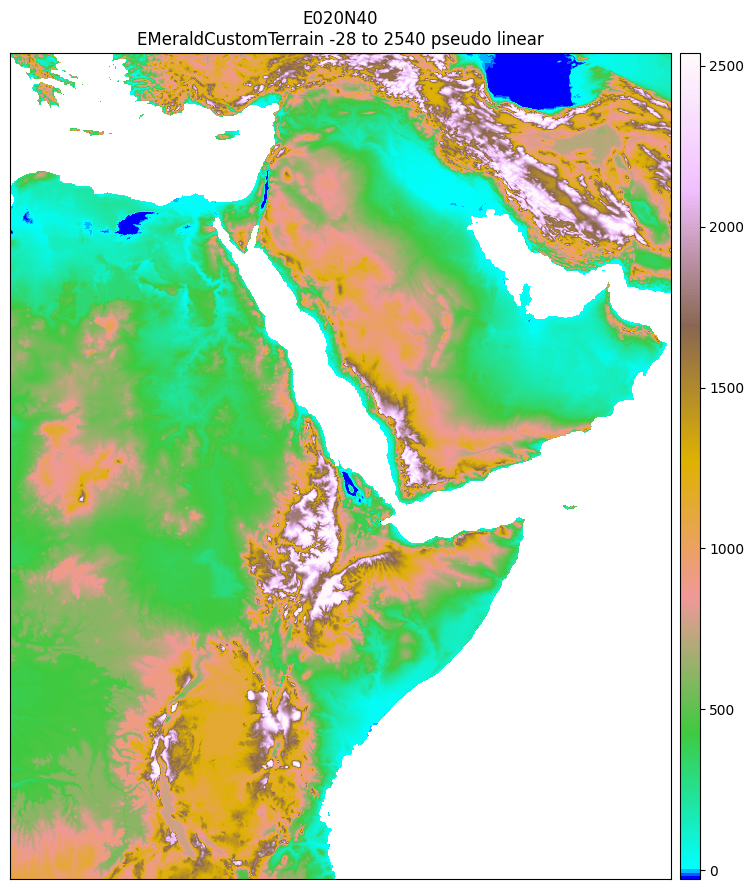


New single-channel colorized geotiff written to: 
	- '/Users/bbloss/EMeraldCodes/disco-tif/example_data/E020N40/E020N40_EMeraldCustomTerrain_-28_to_2540_pseudo_linear.tif'

pl_data_breaks = [-28, 0, 423, 847, 1270, 1693, 2117, 2540]


In [89]:
cmap_method='pseudo_linear'

pl_colormap, pl_data_breaks = disco_tif.process_sb_tiff.make_rgba_tiff_from_single_Band(single_band_tiff_path,
                                                                                        #data_min_max=datarange,
                                                                                        data_min_max=data_min_max,
                                                                                        cmap_method=cmap_method,
                                                                                        min_max_method=min_max_method,
                                                                                        clip_perc=clip_perc,
                                                                                        color_palette_name=color_palette_name,
                                                                                        output_tif=output_tif,
                                                                                        generate_QGIS_lut=output_QGIS_lut,
                                                                                        generate_rgba_luts=output_rgba_lut,
                                                                                        generate_data_uint8_lut=output_uint8_lut,
                                                                                        generate_uint8_luts=output_uint8_lut,
                                                                                        plot_rgba_raster=plot_rgba_raster)

print(f"pl_data_breaks = {pl_data_breaks}")

# build bit for hillshades

In [ ]:
# valid azimuths = [0 : 360]
start_az = 90
#num_az_angles = 8
num_az_angles = 4

# valid alitudes = [0 : 90]
start_al = 30
al_inc = 30
#num_al_angles = 2
num_al_angles = 1

In [ ]:
hs_azimuths, hs_altitudes = disco_tif.hillshades_pca.build_hs_az_al(start_al=start_al, al_inc=al_inc, num_al_angles=num_al_angles, start_az=start_az, num_az_angles=num_az_angles)

In [ ]:
data_min_max = [min(ph_data_breaks), max(ph_data_breaks)]
data_min_max

In [ ]:
hillshades = disco_tif.hillshades_pca.build_hillshade(single_band_tiff_path,
                                                               data_min_max,
                                                               hs_azimuths=[270],
                                                               hs_altitudes=[45],
                                                               #cmap=ph_colormap,
                                                               cmap=pl_colormap,
                                                               process_pca=False,
                                                               plot_figures = True)

In [ ]:
hillshades, pcaComponents = disco_tif.hillshades_pca.build_hillshade(single_band_tiff_path,
                                                                              data_min_max,
                                                                              hs_azimuths,
                                                                              hs_altitudes,
                                                                              cmap=ph_colormap,
                                                                              process_pca=True,
                                                                              plot_figures=True)

# write a mapsource mapfile filename and write the mapfile

In [ ]:
writeLUTs=True
writeTifs=True
writeHillshades=True

In [ ]:
mapfile_path = f"{single_band_tiff_path.split('.tif')[0]}"
if writeLUTs:
    mapfile_path = f"{mapfile_path}_LUT"
if writeTifs:
    mapfile_path = f"{mapfile_path}_AuxTif"
if writeHillshades:
    mapfile_path = f"{mapfile_path}_HS"


mapfile_path = f"{mapfile_path}.map"

mapfile_path

In [ ]:
disco_tif.write_mapfile.generate_LUT_based_mapfile(single_band_tiff_path, mapfile_path, writeLUTs=writeLUTs, writeTifs=writeTifs, writeHillshades=writeHillshades)

In [ ]:
mapdict = {0: (0, 0, 255, 255), 1: (0, 85, 255, 255), 2: (1, 170, 255, 255), 3: (1, 255, 255, 255), 4: (4, 253, 247, 255), 5: (6, 251, 239, 255), 6: (9, 248, 231, 255), 7: (11, 246, 223, 255), 8: (14, 244, 215, 255), 9: (16, 242, 207, 255), 10: (19, 240, 199, 255), 11: (22, 237, 191, 255), 12: (24, 235, 183, 255), 13: (27, 233, 175, 255), 14: (29, 231, 167, 255), 15: (32, 228, 159, 255), 16: (35, 226, 151, 255), 17: (37, 224, 143, 255), 18: (40, 222, 135, 255), 19: (42, 220, 127, 255), 20: (45, 217, 119, 255), 21: (48, 215, 111, 255), 22: (50, 213, 103, 255), 23: (53, 211, 95, 255), 24: (55, 209, 87, 255), 25: (58, 206, 79, 255), 26: (60, 204, 71, 255), 27: (63, 202, 63, 255), 28: (72, 199, 68, 255), 29: (82, 197, 72, 255), 30: (91, 194, 77, 255), 31: (100, 191, 82, 255), 32: (110, 189, 86, 255), 33: (119, 186, 91, 255), 34: (129, 184, 96, 255), 35: (138, 181, 100, 255), 36: (147, 178, 105, 255), 37: (157, 176, 110, 255), 38: (166, 173, 115, 255), 39: (175, 170, 119, 255), 40: (185, 168, 124, 255), 41: (194, 165, 129, 255), 42: (204, 163, 133, 255), 43: (213, 160, 138, 255), 44: (222, 157, 143, 255), 45: (232, 155, 147, 255), 46: (241, 152, 152, 255), 47: (240, 154, 143, 255), 48: (239, 155, 133, 255), 49: (237, 157, 124, 255), 50: (236, 158, 114, 255), 51: (235, 160, 105, 255), 52: (234, 162, 95, 255), 53: (233, 163, 86, 255), 54: (232, 165, 76, 255), 55: (230, 167, 67, 255), 56: (229, 168, 58, 255), 57: (228, 170, 48, 255), 58: (227, 172, 39, 255), 59: (226, 173, 29, 255), 60: (224, 175, 20, 255), 61: (223, 176, 10, 255), 62: (222, 178, 1, 255), 63: (218, 175, 4, 255), 64: (215, 172, 8, 255), 65: (211, 168, 11, 255), 66: (208, 165, 14, 255), 67: (204, 162, 18, 255), 68: (201, 159, 21, 255), 69: (197, 156, 24, 255), 70: (194, 153, 28, 255), 71: (190, 150, 31, 255), 72: (187, 146, 34, 255), 73: (183, 143, 38, 255), 74: (180, 140, 41, 255), 75: (176, 137, 44, 255), 76: (172, 134, 48, 255), 77: (169, 130, 51, 255), 78: (165, 127, 54, 255), 79: (162, 124, 58, 255), 80: (158, 121, 61, 255), 81: (155, 118, 64, 255), 82: (151, 115, 68, 255), 83: (148, 112, 71, 255), 84: (144, 108, 74, 255), 85: (141, 105, 78, 255), 86: (137, 102, 81, 255), 87: (140, 104, 86, 255), 88: (143, 107, 90, 255), 89: (145, 109, 95, 255), 90: (148, 112, 100, 255), 91: (151, 114, 105, 255), 92: (154, 116, 109, 255), 93: (157, 119, 114, 255), 94: (159, 121, 119, 255), 95: (162, 124, 123, 255), 96: (165, 126, 128, 255), 97: (168, 128, 133, 255), 98: (171, 131, 137, 255), 99: (174, 133, 142, 255), 100: (176, 136, 147, 255), 101: (179, 138, 152, 255), 102: (182, 140, 156, 255), 103: (185, 143, 161, 255), 104: (188, 145, 166, 255), 105: (190, 148, 170, 255), 106: (193, 150, 175, 255), 107: (196, 153, 180, 255), 108: (199, 155, 184, 255), 109: (202, 157, 189, 255), 110: (204, 160, 194, 255), 111: (207, 162, 199, 255), 112: (210, 165, 203, 255), 113: (213, 167, 208, 255), 114: (216, 169, 213, 255), 115: (219, 172, 217, 255), 116: (221, 174, 222, 255), 117: (224, 177, 227, 255), 118: (227, 179, 231, 255), 119: (230, 181, 236, 255), 120: (233, 184, 241, 255), 121: (235, 186, 246, 255), 122: (238, 189, 250, 255), 123: (241, 191, 255, 255), 124: (241, 191, 255, 255), 125: (241, 192, 255, 255), 126: (241, 192, 255, 255), 127: (241, 193, 255, 255), 128: (242, 193, 255, 255), 129: (242, 194, 255, 255), 130: (242, 194, 255, 255), 131: (242, 195, 255, 255), 132: (242, 195, 255, 255), 133: (242, 196, 255, 255), 134: (242, 196, 255, 255), 135: (242, 196, 255, 255), 136: (242, 197, 255, 255), 137: (242, 197, 255, 255), 138: (243, 198, 255, 255), 139: (243, 198, 255, 255), 140: (243, 199, 255, 255), 141: (243, 199, 255, 255), 142: (243, 200, 255, 255), 143: (243, 200, 255, 255), 144: (243, 200, 255, 255), 145: (243, 201, 254, 255), 146: (243, 201, 254, 255), 147: (244, 202, 254, 255), 148: (244, 202, 254, 255), 149: (244, 203, 254, 255), 150: (244, 203, 254, 255), 151: (244, 204, 254, 255), 152: (244, 204, 254, 255), 153: (244, 205, 254, 255), 154: (244, 205, 254, 255), 155: (244, 205, 254, 255), 156: (245, 206, 254, 255), 157: (245, 206, 254, 255), 158: (245, 207, 254, 255), 159: (245, 207, 254, 255), 160: (245, 208, 254, 255), 161: (245, 208, 254, 255), 162: (245, 209, 254, 255), 163: (245, 209, 254, 255), 164: (245, 209, 254, 255), 165: (245, 210, 254, 255), 166: (246, 210, 254, 255), 167: (246, 211, 254, 255), 168: (246, 211, 254, 255), 169: (246, 212, 254, 255), 170: (246, 212, 254, 255), 171: (246, 213, 254, 255), 172: (246, 213, 254, 255), 173: (246, 214, 254, 255), 174: (246, 214, 254, 255), 175: (247, 214, 254, 255), 176: (247, 215, 254, 255), 177: (247, 215, 254, 255), 178: (247, 216, 254, 255), 179: (247, 216, 254, 255), 180: (247, 217, 254, 255), 181: (247, 217, 254, 255), 182: (247, 218, 254, 255), 183: (247, 218, 254, 255), 184: (248, 218, 254, 255), 185: (248, 219, 254, 255), 186: (248, 219, 254, 255), 187: (248, 220, 254, 255), 188: (248, 220, 254, 255), 189: (248, 221, 253, 255), 190: (248, 221, 253, 255), 191: (248, 222, 253, 255), 192: (248, 222, 253, 255), 193: (248, 223, 253, 255), 194: (249, 223, 253, 255), 195: (249, 223, 253, 255), 196: (249, 224, 253, 255), 197: (249, 224, 253, 255), 198: (249, 225, 253, 255), 199: (249, 225, 253, 255), 200: (249, 226, 253, 255), 201: (249, 226, 253, 255), 202: (249, 227, 253, 255), 203: (250, 227, 253, 255), 204: (250, 227, 253, 255), 205: (250, 228, 253, 255), 206: (250, 228, 253, 255), 207: (250, 229, 253, 255), 208: (250, 229, 253, 255), 209: (250, 230, 253, 255), 210: (250, 230, 253, 255), 211: (250, 231, 253, 255), 212: (251, 231, 253, 255), 213: (251, 232, 253, 255), 214: (251, 232, 253, 255), 215: (251, 232, 253, 255), 216: (251, 233, 253, 255), 217: (251, 233, 253, 255), 218: (251, 234, 253, 255), 219: (251, 234, 253, 255), 220: (251, 235, 253, 255), 221: (251, 235, 253, 255), 222: (252, 236, 253, 255), 223: (252, 236, 253, 255), 224: (252, 236, 253, 255), 225: (252, 237, 253, 255), 226: (252, 237, 253, 255), 227: (252, 238, 253, 255), 228: (252, 238, 253, 255), 229: (252, 239, 253, 255), 230: (252, 239, 253, 255), 231: (253, 240, 253, 255), 232: (253, 240, 253, 255), 233: (253, 241, 252, 255), 234: (253, 241, 252, 255), 235: (253, 241, 252, 255), 236: (253, 242, 252, 255), 237: (253, 242, 252, 255), 238: (253, 243, 252, 255), 239: (253, 243, 252, 255), 240: (254, 244, 252, 255), 241: (254, 244, 252, 255), 242: (254, 245, 252, 255), 243: (254, 245, 252, 255), 244: (254, 245, 252, 255), 245: (254, 246, 252, 255), 246: (254, 246, 252, 255), 247: (254, 247, 252, 255), 248: (254, 247, 252, 255), 249: (254, 248, 252, 255), 250: (255, 248, 252, 255), 251: (255, 249, 252, 255), 252: (255, 249, 252, 255), 253: (255, 250, 252, 255), 254: (255, 250, 252, 255), 255: (127, 127, 127, 0)}

In [ ]:
mapdict

In [ ]:
df = pd.DataFrame.from_dict(mapdict, orient='index', columns=['r','g','b','a'])
df
    

In [ ]:
str_r = ''
str_g = ''
str_b = ''
str_a = ''
for indicies in df.index.values:
    str_r = str_r + f"{indicies}:{df.loc[indicies,'r']},"
    str_g = str_g + f"{indicies}:{df.loc[indicies,'g']},"
    str_b = str_b + f"{indicies}:{df.loc[indicies,'b']},"
    str_a = str_a + f"{indicies}:{df.loc[indicies,'a']},"



In [ ]:
#str_r
#str_g
#str_b
str_a
